<a href="https://colab.research.google.com/github/thamizhannal/eva5/blob/master/EVA5_Session_6_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target:

Have reached 99.58% validation accuracy for L2+BN, with GBN & L1&L2 with GBN . 



### Results:

1. Parameters: 8002
2. Best Train Accuracy: 99.08%
3. Best Test Accuracy: 99.58%
4. greater than 99.4% in consistently >4 epochs

### Analysis:

**Lambda used for L1 loss is 0.001**. Have used grid search and experimented L1 loss with various values such as 0.01, 0.03, 0.001, 0.003, 0.0001 & 0.0003 and found that 0.001 was optimal and have got validation accuracy as 99%.  

**Weigh decay used for L2 is 0.0001.** We used grid search and experimented weight decay various weight decay values 0.01, 0.03, 0.001, 0.003, 0.0001 & 0.0003 and seen that optimal value was  0.0001.

### Loss Curve Analysis:

 **L1 loss curve:** It is fluctuating a lot, not smoother and reduced slightly from where it has started. Loss started with 0.2 and increased to 0.3 at 8th epoch, after that stated reducing gradually and reached to 0.08.

 **L1 & L2 Loss curve:** This loss also looks much similar to L1 loss function but fluctuating slightly lesser as compare to L1 loss. 

 **L2 Loss, GBN Loss & L1L2GBN loss curve** looks much similar and smoother. Loss starts reducing as epoch progresses and after a point loss between these models looks narrow and like single line.


#### Accuracy Curve 

**L1 accuracy and L1&L2 accuracy curves ** looks similar, but L1 accuracy curve fluctuates a lot compare to L1L2 curve.

L1  and L1&L2 regularization both methods does not improves accuracy much. After 25 epochs it improved it improved accuracy by 2%. (96% at 1st epoch and 98% at 25th epoch)

Seems L1 Regularization create more fluctuation in loss & accuracy curve and does not improve model much.

**L2 Regularization**: This curve is very smooth, gradually increasing and  more consistent. It has started at 98% at 1st epoch and start improving gradually and reached 99.58% at the end of 25th epoch. 

**L2 Reg, GBN Only and L1L2 with GBN validation accuracies**  curve looks much smoother, consistently improving. 

**Best Model:**  **Thought L2 Reg, GBN Only and L1L2 with GBN validation accuracies exhibits similar validation accuracies,  L1L2 with GBN outperform all other models  it reached validation highest validation accuracy 99.5% at train accuracy of 99.1%. Looks this model has more scope to push validation accuracy further**. 


 

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [9]:
# Reused below code from https://github.com/apple/ml-cifar-10-faster/blob/master/utils.py
# GhostBatchNormalization
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)
            

In [10]:
num_splits = 2
#Receptive field is calcualted based on actual formula
class Net(nn.Module):
    def __init__(self, enable_bn=True ):
        super(Net, self).__init__()
        self.enable_bn = enable_bn

        #block1
        self.conv1 = nn.Conv2d(1, 8, 3,padding = True) #o/p size:28; rf: 3
        self.Batchnorm1 = nn.BatchNorm2d(8)
        if not enable_bn:
            self.Batchnorm1 = GhostBatchNorm(num_features=8, num_splits=num_splits)
        
        self.conv2 = nn.Conv2d(8, 16, 3) #o/p size: 26; rf: 5
        self.Batchnorm2 = nn.BatchNorm2d(16)
        if not enable_bn:
            self.Batchnorm2 = GhostBatchNorm(num_features=16, num_splits=num_splits)


        #transition block
        self.pool1 = nn.MaxPool2d(2, 2) #o/p size: 13; rf: 6
        self.pool1trns = nn.Conv2d(16, 10, 1)#o/p size: 13; rf: 6 
        self.Batchnormtrns1 = nn.BatchNorm2d(10)
        if not enable_bn:
            self.Batchnormtrns1 = GhostBatchNorm(num_features=10, num_splits=num_splits)
        
        #block2
        self.conv3 = nn.Conv2d(10,14,3) #o/p size: 11; rf: 10 # 14
        self.Batchnorm3 = nn.BatchNorm2d(14)
        if not enable_bn:
            self.Batchnorm3 = GhostBatchNorm(num_features=14, num_splits=num_splits)

        self.dp3 = nn.Dropout(p = 0.10) 
        self.conv4 = nn.Conv2d(14, 16, 3) #o/p size: 9; rf: 14
        self.Batchnorm4 = nn.BatchNorm2d(16)
        if not enable_bn:
            self.Batchnorm4 = GhostBatchNorm(num_features=16, num_splits=num_splits)

        self.dp4 = nn.Dropout(p = 0.10)
        self.conv5 = nn.Conv2d(16, 20, 3) #o/p size: 7; rf: 18
        self.Batchnorm5 = nn.BatchNorm2d(20)
        if not enable_bn:
            self.Batchnorm5 = GhostBatchNorm(num_features=20, num_splits=num_splits)

        self.dp5 = nn.Dropout(p = 0.10)

        #gap and 1X1 
        self.conv6_avgp = nn.AvgPool2d(kernel_size=7) #o/p size: 1; rf: 30
        self.pool2trns = nn.Conv2d(20,10,1) #6


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.Batchnorm1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.Batchnorm2(x)


        x = self.pool1(x)
        x = self.pool1trns(x)
        x = F.relu(x)
        x = self.Batchnormtrns1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.Batchnorm3(x)
        x = self.dp3(x)
 
        x = self.conv4(x)
        x = F.relu(x)
        x = self.Batchnorm4(x)
        x = self.dp4(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.Batchnorm5(x)
        x = self.dp5(x)

        x = self.conv6_avgp(x)

        x = self.pool2trns(x)


        x = x.view(-1, 10)
        return F.log_softmax(x,dim=-1)

In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(True).to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 26, 26]           1,168
       BatchNorm2d-4           [-1, 16, 26, 26]              32
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 10, 13, 13]             170
       BatchNorm2d-7           [-1, 10, 13, 13]              20
            Conv2d-8           [-1, 14, 11, 11]           1,274
       BatchNorm2d-9           [-1, 14, 11, 11]              28
          Dropout-10           [-1, 14, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,032
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 2

In [12]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [13]:
train_losses, train_accuracy = [], []
val_losses = []
val_accuracy = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, 
          enable_l1=False, enable_l2=False, enable_gbn=False):
    model.train()
    #pbar = tqdm(train_loader)
    train_loss = 0 
    train_correct = 0
    train_acc = 0

    # For best lambda value, apply grid search
    lambda_l1 = 0.001
    #scheduler.step()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        # loss function
        # L1 loss
        if (enable_l1 and not (enable_l2 and enable_gbn)):
            l1_loss = 0
            for param in model.parameters():
                l1_loss = l1_loss + param.abs().sum()
            loss = loss + lambda_l1 * l1_loss

        loss.backward()
        optimizer.step()
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()

    #
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    #train_loss /= len(test_loader.dataset)
    
    print('Epoch: {:.0f},LR: {}.\nTrain set: train Average loss: {:.4f}, train_Accuracy: {}/{} ({:.4f}%)\n'.format(
        epoch,optimizer.param_groups[0]['lr'],train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return train_losses,train_accuracy
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            pred_test = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred_test.eq(target.view_as(pred_test)).sum().item()

    test_loss /= len(test_loader.dataset)
    val_acc = 100. * correct / len(test_loader.dataset)

    
    print('Test set: test Average loss: {:.4f}, test Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, val_acc
    


In [14]:
from torch.optim.lr_scheduler import StepLR

# Loop To Run Network 
# 1. with L1 + BN
# 2. with L2 + BN
# 3. with L1 and L2 with BN
# 4. with GBN
# 5. with L1 and L2 with GBN

losses = ['l1', 'l2', 'l1&l2', 'gbn', 'l1l2gbn']

val_losses = []
val_accs = []

for idx in range(len(losses)): #len(losses)):
    i = idx+1
    enable_l1 = False
    enable_l2 = False
    enable_gbn = False

    print("{} {} loss".format((i),losses[idx]))
    ######### Model Initialization #############################################
    # Enable BN for option 1, 2 & 3
    if i == 1 or i==2 or i==3:
        model = Net(enable_bn=True).to(device)
        print("BN enabled for option: {}".format(i))
    # Enable GBN for option 4 & 5( disable BN)
    elif i==4 or i==5:
        model = Net(enable_bn=False).to(device)
        print("GBN Enabled & BN disabled for option: {}".format(i))
    print ("Model Summary:")
    summary(model, input_size=(1, 28, 28))

    ########## Optimizer Initialization #######################################
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    if i==2 or i==3 or i==5:
        # decay of 0.0001 gave best val accuracy 99.38
        decay = 0.0001
        optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=decay)  
        print("Weight decay {} set for option: {}".format(decay, i))
    
    scheduler = StepLR(optimizer, step_size=4, gamma=0.8)
    ######### Loss Function Selection #########################################
    if i==1:
         enable_l1 = True
         print("LOSS: l1 loss enabled")
    elif i==2:
         enable_l2 = True
         print("LOSS: l2 loss enabled")
    elif i==3:
         enable_l1 = True
         enable_l2=True
         print("LOSS: l1l2 loss enabled")
    elif i==4:         
         enable_gbn = True
         print("LOSS: gbn loss enabled")
    elif i==5:
         enable_l1 = True
         enable_l2=True
         enable_gbn = True
         print("LOSS: l1l2gbn loss enabled")
    val_loss = []
    val_acc = []
    for epoch in range(1, 26):
        train(model, device, train_loader, optimizer, epoch, 
              enable_l1=enable_l1, enable_l2=enable_l2, enable_gbn=enable_gbn)
        scheduler.step()
        loss, acc = test(model, device, test_loader)
        val_loss.append(loss)
        val_acc.append(acc)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save GBN Model
    if i == 4:
        PATH = "gbn_model.pt"
        torch.save(model, PATH)
        print("GBN Model saved at {}".format(PATH))


1 l1 loss
BN enabled for option: 1
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 26, 26]           1,168
       BatchNorm2d-4           [-1, 16, 26, 26]              32
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 10, 13, 13]             170
       BatchNorm2d-7           [-1, 10, 13, 13]              20
            Conv2d-8           [-1, 14, 11, 11]           1,274
       BatchNorm2d-9           [-1, 14, 11, 11]              28
          Dropout-10           [-1, 14, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,032
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]      

### Validation Accuracy & Loss Plot


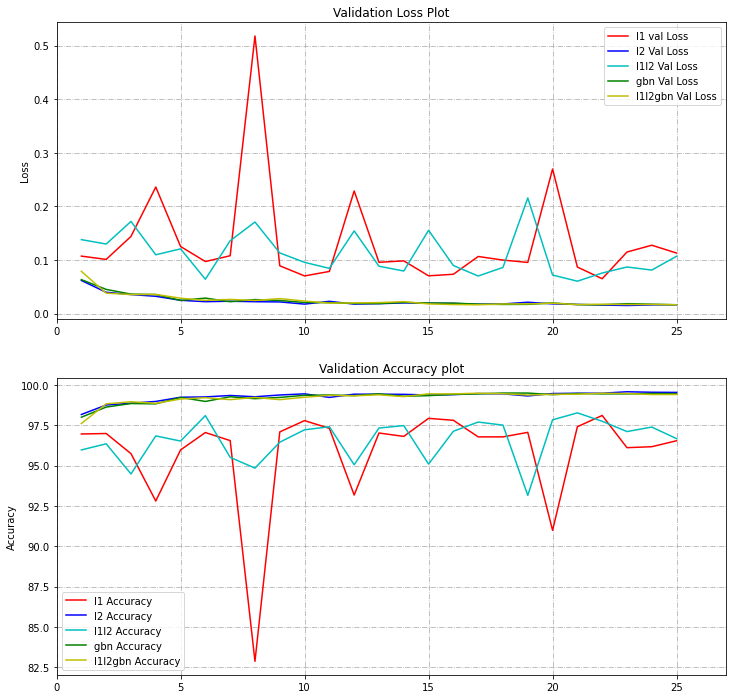

In [15]:
import matplotlib.pyplot as plt

epoch = 25
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Loss')
plt.title('Validation Loss Plot')
plt.plot(range(1, epoch+1), val_losses[0], 'r', label='l1 val Loss')
plt.plot(range(1, epoch+1), val_losses[1], 'b', label='l2 Val Loss')
plt.plot(range(1, epoch+1), val_losses[2], 'c', label='l1l2 Val Loss')
plt.plot(range(1, epoch+1), val_losses[3], 'g', label='gbn Val Loss')
plt.plot(range(1, epoch+1), val_losses[4], 'y', label='l1l2gbn Val Loss')


ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)

ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.title('Validation Accuracy plot')
plt.plot(range(1, epoch+1), val_accs[0], 'r', label='l1 Accuracy')
plt.plot(range(1, epoch+1), val_accs[1], 'b', label='l2 Accuracy')
plt.plot(range(1, epoch+1), val_accs[2], 'c', label='l1l2 Accuracy')
plt.plot(range(1, epoch+1), val_accs[3], 'g', label='gbn Accuracy')
plt.plot(range(1, epoch+1), val_accs[4], 'y', label='l1l2gbn Accuracy')

ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [22]:
# Misclassified Image Plotting

#PATH = "gbn_model.pt"
#torch.save(model, PATH)

# Save Model
model = torch.load(PATH)
model.eval()

tot = 0
data_ = []
target_ = []
pred_ = []
correct = 0
tot_correct = 0
indx = []

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct += pred.eq(target.view_as(pred)).sum().item()
  equals = pred.eq(target.view_as(pred)).tolist()
    
  for idx in range(0,len(equals)):
    if equals[idx] == [False]:
      indx.append(idx)
      data_.append(data[idx])
      target_.append(target[idx])
      pred_.append(pred[idx])

  if len(indx) >= 25:
    break

In [23]:

# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,12), rows=5, interp=False,titles = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None:
            sp.set_title("Actual:{}".format(titles[i].tolist(), fontsize=16))
        sp.axis('Off')
        plt.imshow((torch.squeeze(ims[i]).tolist()))

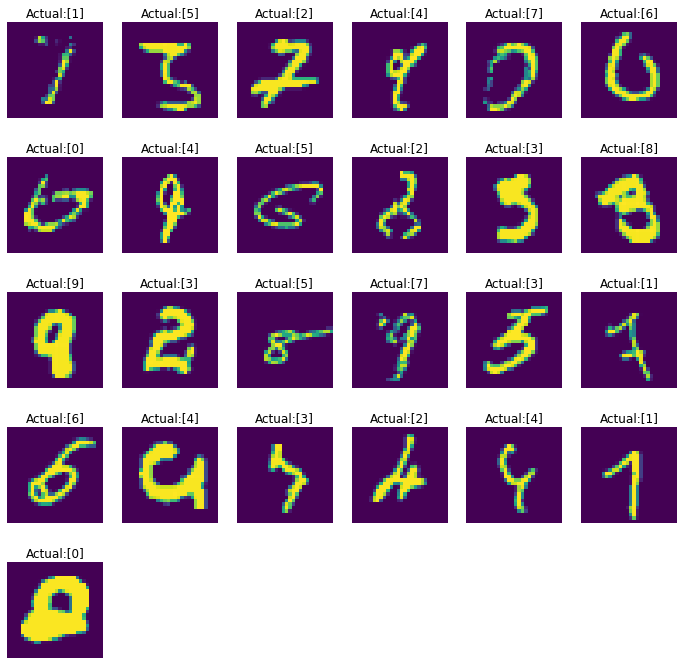

In [24]:
plots(data_,titles = pred_)